In [1]:
from MNIST_dataloader import Noisy_MNIST
from Fast_MRI_dataloader import Fast_MRI
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
from tqdm import tqdm 
import PIL

In [2]:
#Bram
#data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
#Amin
data_loc = 'C://Users//amin2//Documents//School//5LSL0ML//5LSL0//data//Fast_MRI_Knee'

In [3]:

# %% dataloader for the Fast MRI dataset
def create_dataloaders_mri(data_loc, batch_size):
    dataset_train = Fast_MRI("train", data_loc)
    dataset_test  = Fast_MRI("test" , data_loc)
    
    Fast_MRI_train_loader =  DataLoader(dataset_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Fast_MRI_test_loader  =  DataLoader(dataset_test , batch_size=batch_size, shuffle=True, drop_last=False)
    
    return Fast_MRI_train_loader, Fast_MRI_test_loader


In [4]:
# %% dataloader for the Noisy MNIST dataset
def create_dataloaders_noisy_mnist(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader

In [5]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [61]:
# %%
# Week 1
# 1A create python function for denoising MNIST
# ISTA function for denoising
def ista_denoise(batch, step_size, num_iterations, lambda_val):
    #iterate over all images in batch
    _, _, height, width = batch.shape
    denoised_list = []
    for img in batch:
        img = img.numpy()
        #signal estimator
        x = img
        #sensing matrix
        A = np.identity(height)
        # Perform ISTA denoising
        for i in range(num_iterations):
            # Update the denoised image
            x = x - step_size* x + step_size * img
            x = torch.from_numpy(x)
            x = torch.add(x,1)
            x = soft_threshold(x,lambda_val)
            x = torch.add(x,-1)
            x = x.numpy()
        denoised_image = x
        denoised_list.append(denoised_image)
    return denoised_list

def soft_threshold(x, threshold):
    return torch.sign(x) * torch.max(torch.abs(x) - threshold,torch.zeros_like(x))



0.15365560576319695


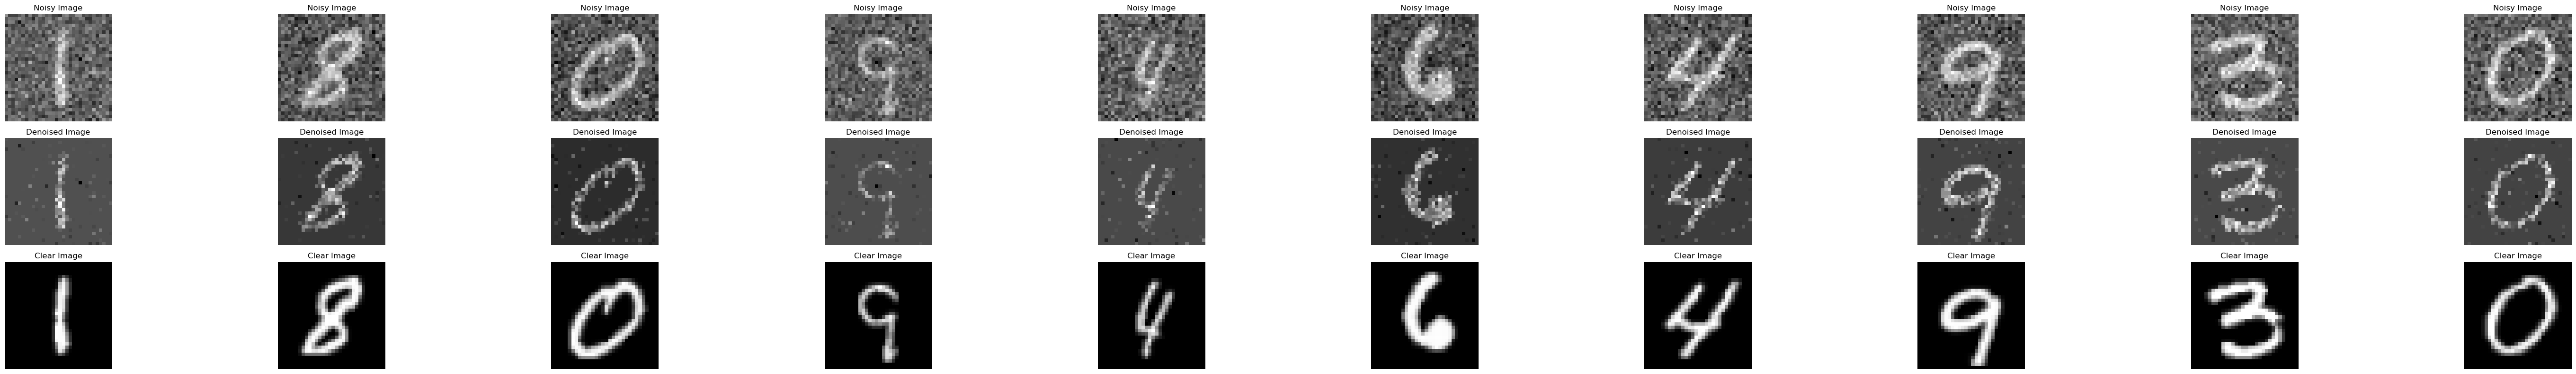

In [74]:
batch_size = 10
    
# get dataloader
train_loader, test_loader = create_dataloaders_noisy_mnist(data_loc, batch_size)
    
# get some examples
training_set = enumerate(train_loader)
_, (x_clean, x_noisy, labels) = next(training_set)

test_set = enumerate(test_loader)
_, (x_clean_test, x_noisy_test, labels_test) = next(test_set)

# %% 1B Show results of denoising
# Define constants
mu = 0.001
K = 120
lambda_val = 0.008

# Create empty lists
clear_images_list = []
noisy_images_list = []
count = 0
avg_mse = 0

denoised_images = ista_denoise(x_noisy, step_size=mu, num_iterations=K, lambda_val=lambda_val)



for i in range(len(x_clean)):
     y = x_clean[i].reshape(32,32).numpy() 
     y_pred = denoised_images[i]
     mse = np.mean((y - y_pred)**2)
     count +=1
     avg_mse += mse
avg_mse /=count
print(avg_mse)

num_images = len(denoised_images)

 # Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=3, ncols=num_images, figsize=(6 * num_images, 8))

for i in range(num_images):
#     # Get the noisy image and denoised image for the current iteration
     noisy_images_np = x_noisy[i].squeeze()
     clear_image_np = x_clean[i].squeeze()
     denoised_image_np = denoised_images[i].squeeze()

#     # Plot the denoised image in the first row of subplots
     axes[0, i].imshow(noisy_images_np, cmap='gray')
     axes[0, i].set_title('Noisy Image')
     axes[0, i].axis('off')  

#     # Plot the denoised image in the first row of subplots
     axes[1, i].imshow(denoised_image_np, cmap='gray')
     axes[1, i].set_title('Denoised Image')
     axes[1, i].axis('off')  

#     # Plot the clear image in the second row of subplots
     axes[2, i].imshow(clear_image_np, cmap='gray')
     axes[2, i].set_title('Clear Image')
     axes[2, i].axis('off')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Save Figure

#plt.savefig('1B_denoised_ISTA')

0.14638339653611182


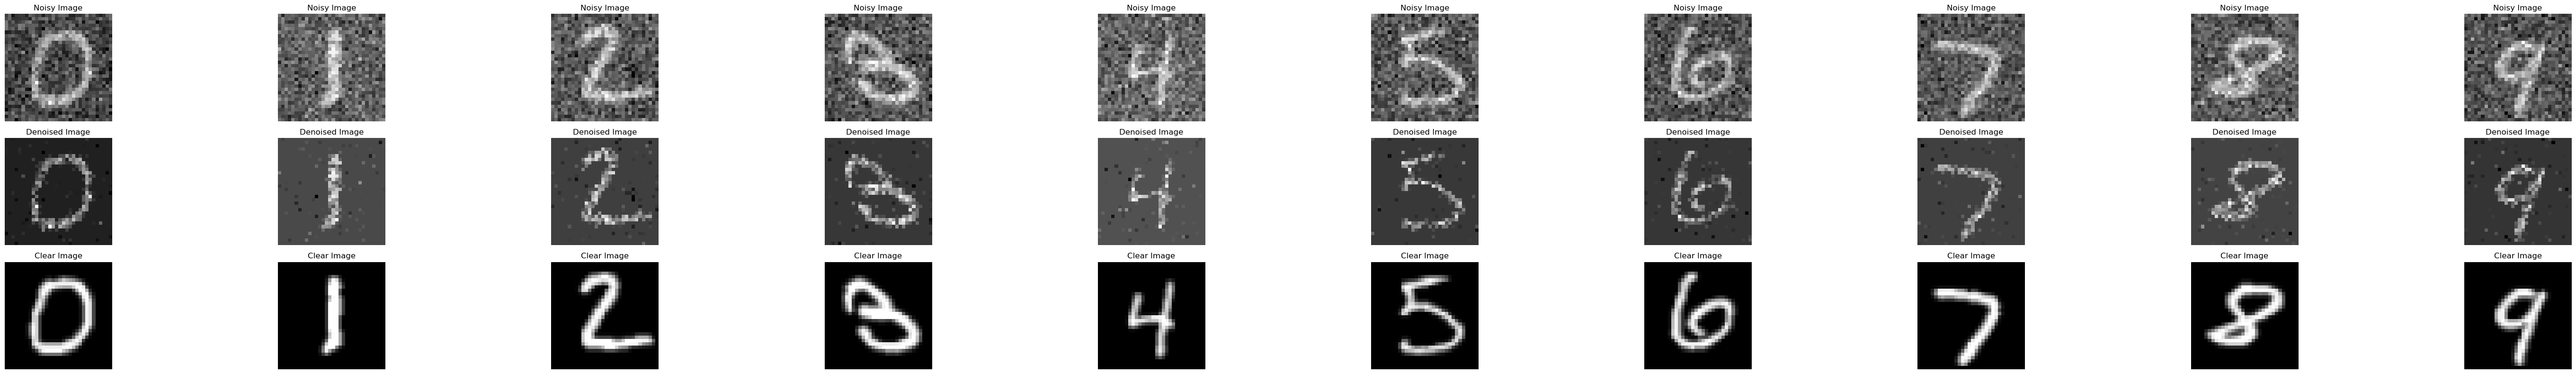

In [77]:
avg_mse = 0
count = 0
denoised_images_test = ista_denoise(x_noisy_test, step_size=mu, num_iterations=K, lambda_val=lambda_val)
for i in range(len(x_clean_test)):
     y = x_clean_test[i].reshape(32,32).numpy() 
     y_pred = denoised_images_test[i]
     mse = np.mean((y - y_pred)**2)
     count +=1
     avg_mse += mse
avg_mse /=count
print(avg_mse)

num_images = len(denoised_images)

 # Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=3, ncols=num_images, figsize=(6 * num_images, 8))

for i in range(num_images):
#     # Get the noisy image and denoised image for the current iteration
     noisy_images_np = x_noisy_test[i].squeeze()
     clear_image_np = x_clean_test[i].squeeze()
     denoised_image_np = denoised_images_test[i].squeeze()

#     # Plot the denoised image in the first row of subplots
     axes[0, i].imshow(noisy_images_np, cmap='gray')
     axes[0, i].set_title('Noisy Image')
     axes[0, i].axis('off')  

#     # Plot the denoised image in the first row of subplots
     axes[1, i].imshow(denoised_image_np, cmap='gray')
     axes[1, i].set_title('Denoised Image')
     axes[1, i].axis('off')  

#     # Plot the clear image in the second row of subplots
     axes[2, i].imshow(clear_image_np, cmap='gray')
     axes[2, i].set_title('Clear Image')
     axes[2, i].axis('off')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()